Cluster fingerprints, view PCA
-------



_* No maps, timelines, spectrograms, features here. That is in next notebook, "Visualization"_


-------

**1. Kmeans clustering on FPs based on PVE**

**2. Clustering metric (silhouette score) to choose Kopt - optimal number of clusters**

**3. Visualize clustering with PCA**

**4. Find repeaters in clusters**

    * load repeater catalog
    * plot REQ in PCA
    * make plot like Felix to show where REQs are (xaxis: REQ event number, yaxis: number of clusters??

-------

_**TODO:**_

* Plot PCA figures
* Visualize clustering with silhouette score plots
* Adapt find_Kopt function for euclidean distance (in notebook_functions.py)


-------


In [1]:
pwd

'/Users/theresasawi/Documents/12_Projects/sareq_sawietal/notebooks'

In [2]:

import numpy as np
import h5py
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
import pandas as pd
from matplotlib import pyplot as plt

import sys
sys.path.append('../src/data/')
sys.path.append('src/')

sys.path.append('/Users/theresasawi/Documents/12_Projects/specufex_processing/3_post/1_clustering/functions/')
# sys.path.append('/Users/theresasawi/Documents/11_Manuscripts/Sawietal_2021/SawiEtAl_2021/src/visualization/')

from importlib import reload
import functions_clustering as funclust
reload(funclust)


# from functions2 import linearizeFP, PCAonFP, PVEofPCA, getTopFCat

from notebook_functions import linearizeFP, PVEofPCA, getTopFCat, findKmeansKopt,selectKmeans,plotPCA

import yaml

import argparse

from matplotlib import cm

# plt.rcParams['image.cmap']='magma'

# plt.rcParams.update({'font.size': 8})

# cmap=cm.get_cmap('rainbow')


# colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))





### Load config yaml file

In [3]:
yamlPath = "/Users/theresasawi/Documents/12_Projects/sareq_sawietal/SAREQ_00.yaml"

with open(yamlPath) as stream:
    config = yaml.safe_load(stream)

## Set paths, variables

In [5]:
## make separate catalog of rep IDs

csv_repeater = pd.read_csv('../data/processed/catrep.txt',skiprows=0,sep='\s+')#,names=cat_columns)

repeater_IDs = [indd[0] for indd in csv_repeater.index]

## add boolean "isRepeater" column to sgram catalog' [could do this at outset]
isRepeater = sgram_cat['ev_ID'].isin(repeater_IDs)

sgram_cat['isRepeater'] = isRepeater

# cat_repeater = sgram_cat[isRepeater]


### Linearize fingerprints

In [6]:
ev_IDs = sgram_cat.ev_ID

X = linearizeFP(SpecUFEx_H5_path,ev_IDs) #event IDs needed to get fp from H5

print(X.shape)

(3515, 225)


### PCA on fingerprints - FORCING 6 PCs (18% PVE)



In [7]:
PCA_df, numPCA, cum_pve = PVEofPCA(X,numPCMax=6,cum_pve_thresh=.86,stand='MinMax',verbose=0)


numPCA 5 ; cum_pve 0.18608902563066898


In [8]:
## feature space is reduced
X.shape, PCA_df.shape

((3515, 225), (3515, 5))

## Kmeans on fingerprints

In [9]:
clusteringParams_config = config['clusteringParams']
Kmax = clusteringParams_config["Kmax"]

Kmax = 20

print('Kmax', Kmax)
range_n_clusters = range(2,Kmax)

Kmax 20


In [10]:
#could visualize these metrics for a million times better analysis
## easy: box and whisker (or violin)
## like the way silhouette scores are named after **face palm**


Kopt, cluster_labels_best, metric_thresh, elbo_plot = findKmeansKopt(X=np.array(PCA_df),
                                                                     range_n_clusters=range_n_clusters,
                                                                     clusterMetric='silhScore',
                                                                     verbose=0)




kmeans on 2 clusters...
max mean silhouette score:  0.27346068498577536
kmeans on 3 clusters...
max mean silhouette score:  0.27564872303515203
kmeans on 4 clusters...
max mean silhouette score:  0.28189035383624617
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
kmeans on 11 clusters...
kmeans on 12 clusters...
kmeans on 13 clusters...
kmeans on 14 clusters...
kmeans on 15 clusters...
kmeans on 16 clusters...
kmeans on 17 clusters...
kmeans on 18 clusters...
kmeans on 19 clusters...
Best cluster: 4


## Plot PCA by auto Kopt 

In [11]:
print('Kopt',Kopt)

Kopt 4


In [12]:
colors =cm.tab10(range(0,Kopt))

In [13]:
PCA_df['Cluster'] = cluster_labels_best
cat_repeater = PCA_df[isRepeater]




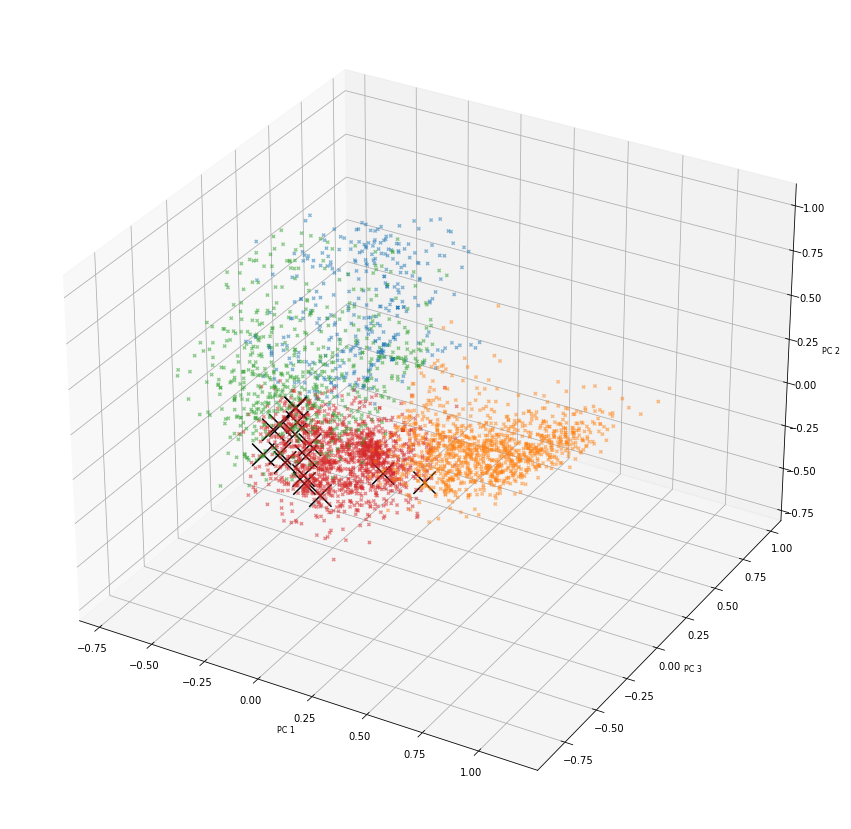

In [14]:
width1 = height1 = 15
fig,axes = plt.subplots(figsize = (width1,height1))
plt.box(False)
plt.xticks(ticks=[])
plt.yticks(ticks=[])

ax = fig.add_subplot(111, projection='3d')

plotPCA(PCA_df,
        cat_repeater,
        Kopt, 
        colors,
        size=10,
        size2=500, 
        alpha=.5,
        labelpad = 5,
        fontsize=8,
        ax=None, 
        fig=None)

### Force Kopt to be higher 

In [15]:

for Kopt in [15,1000]:
    
    Kopt_df, silh_scores_mean = selectKmeans(X,ev_IDs,Kopt,clusterMetric='silhScore')

    PCA_df['Cluster'] = Kopt_df['Cluster']
    PCA_df['SS'] = Kopt_df['SS']
    PCA_df['euc_dist'] = Kopt_df['euc_dist']

    cat_repeater = PCA_df[isRepeater]

    print(f'\n {Kopt} clusters  \n ...')


    repeater_Cluster_list = np.unique(cat_repeater.Cluster)
    
    
    for repeater_Cluster in repeater_Cluster_list:


        print(f'\n Cluster {repeater_Cluster} \n')
        numRepeatersClus = len(cat_repeater[cat_repeater.Cluster==repeater_Cluster])
        numEQsClus = len(PCA_df[PCA_df.Cluster==repeater_Cluster])



        perc_A = numRepeatersClus / len(cat_repeater) * 100


        perc_B = numRepeatersClus/ numEQsClus * 100

        perc_C = numEQsClus / len(PCA_df) * 100






        print(f'{perc_A:.3f}', f'% of repeaters ({numRepeatersClus}/{len(cat_repeater)}) are in Cluster {repeater_Cluster} \n')

        print(f'{perc_B:.3f}', f'% of Cluster {repeater_Cluster} earthquakes ({numRepeatersClus}/{numEQsClus}) are repeaters \n ')

        print(f'{perc_C:.3f}', f'% of all earthquakes ({numEQsClus}/{len(PCA_df)}) are in Cluster {repeater_Cluster}/{Kopt} \n \n ')

        print(' \n ... \n ...')
        print(' \n ... \n ...')
        print(' \n ... \n ...')
        


max mean silhouette score:  0.14244811425991985

 15 clusters  
 ...

 Cluster 2 

6.250 % of repeaters (1/16) are in Cluster 2 

2.500 % of Cluster 2 earthquakes (1/40) are repeaters 
 
1.138 % of all earthquakes (40/3515) are in Cluster 2/15 
 
 
 
 ... 
 ...
 
 ... 
 ...
 
 ... 
 ...

 Cluster 13 

87.500 % of repeaters (14/16) are in Cluster 13 

3.867 % of Cluster 13 earthquakes (14/362) are repeaters 
 
10.299 % of all earthquakes (362/3515) are in Cluster 13/15 
 
 
 
 ... 
 ...
 
 ... 
 ...
 
 ... 
 ...

 Cluster 14 

6.250 % of repeaters (1/16) are in Cluster 14 

0.207 % of Cluster 14 earthquakes (1/482) are repeaters 
 
13.713 % of all earthquakes (482/3515) are in Cluster 14/15 
 
 
 
 ... 
 ...
 
 ... 
 ...
 
 ... 
 ...
max mean silhouette score:  0.08487673680265825

 1000 clusters  
 ...

 Cluster 24 

37.500 % of repeaters (6/16) are in Cluster 24 

60.000 % of Cluster 24 earthquakes (6/10) are repeaters 
 
0.284 % of all earthquakes (10/3515) are in Cluster 24/1000 
 


## go with last value, k = 1000 to find "missing repeaters"


In [16]:
repeater_Cluster_list

array([ 24,  98, 121, 252, 291, 440, 843])

IndexError: index 4 is out of bounds for axis 0 with size 4

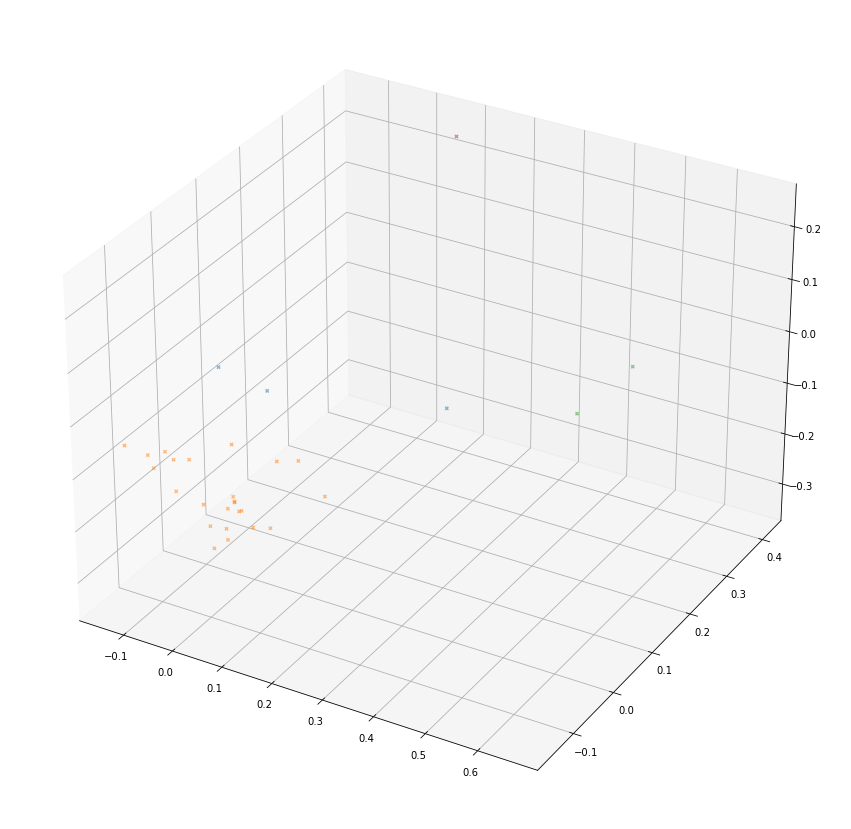

In [17]:


width1 = height1 = 15
fig,axes = plt.subplots(figsize = (width1,height1))
plt.box(False)
plt.xticks(ticks=[])
plt.yticks(ticks=[])

ax = fig.add_subplot(111, projection='3d')

plotPCA(PCA_df,
        cat_repeater,
        Kopt, 
        colors,
        size=10,
        size2=500, 
        alpha=.5,
        labelpad = 5,
        fontsize=8,
        ax=None, 
        fig=None)

